# <center> ARIMA model to predict Stock prices <center>

In [62]:
!pip install yfinance

In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import *
from sklearn.metrics import *

In [64]:
vix = yf.Ticker("^VIX")
vix.info

{'algorithm': None,
 'ask': 0,
 'askSize': 0,
 'averageDailyVolume10Day': 0,
 'averageVolume': 0,
 'averageVolume10days': 0,
 'beta': None,
 'bid': 0,
 'bidSize': 0,
 'circulatingSupply': None,
 'currency': 'USD',
 'dayHigh': 29.44,
 'dayLow': 24.56,
 'dividendRate': None,
 'dividendYield': None,
 'exDividendDate': None,
 'exchange': 'WCB',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EST',
 'expireDate': None,
 'fiftyDayAverage': 29.122286,
 'fiftyTwoWeekHigh': 85.47,
 'fiftyTwoWeekLow': 11.42,
 'fiveYearAvgDividendYield': None,
 'forwardPE': None,
 'fromCurrency': None,
 'gmtOffSetMilliseconds': '-18000000',
 'isEsgPopulated': False,
 'lastMarket': None,
 'logo_url': '',
 'market': 'us_market',
 'marketCap': None,
 'maxAge': 1,
 'maxSupply': None,
 'messageBoardId': 'finmb_INDEXVIX',
 'navPrice': None,
 'open': 27.87,
 'openInterest': None,
 'payoutRatio': None,
 'previousClose': 27.58,
 'priceHint': 2,
 'priceToSalesTrailing12Months': None,
 'quoteType

In [65]:
hist = vix.history(period = "max")
hist.to_csv('VIX.csv')

In [66]:
vix = pd.read_csv('VIX.csv')
vix['Date'] = pd.to_datetime(vix['Date'])

In [67]:
series = vix['Close']

In [68]:
train_split_date = '2000-12-29'
train_split_index = np.where(vix.Date == train_split_date)[0][0]
x_train = vix.loc[cac['Date'] <= train_split_date]['Close']

In [69]:
test_split_date = '2018-01-02'
test_split_index = np.where(vix.Date == test_split_date)[0][0]
x_test = vix.loc[vix['Date'] >= test_split_date]['Close']

In [70]:
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = vix.loc[(cac['Date'] < test_split_date) & (vix['Date'] > train_split_date)]['Close']

In [71]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01) :
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize = (16, 10))
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test :')
    dftest = adfuller(timeseries, autolag = 'AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items() :
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else :
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
        print(dfoutput)

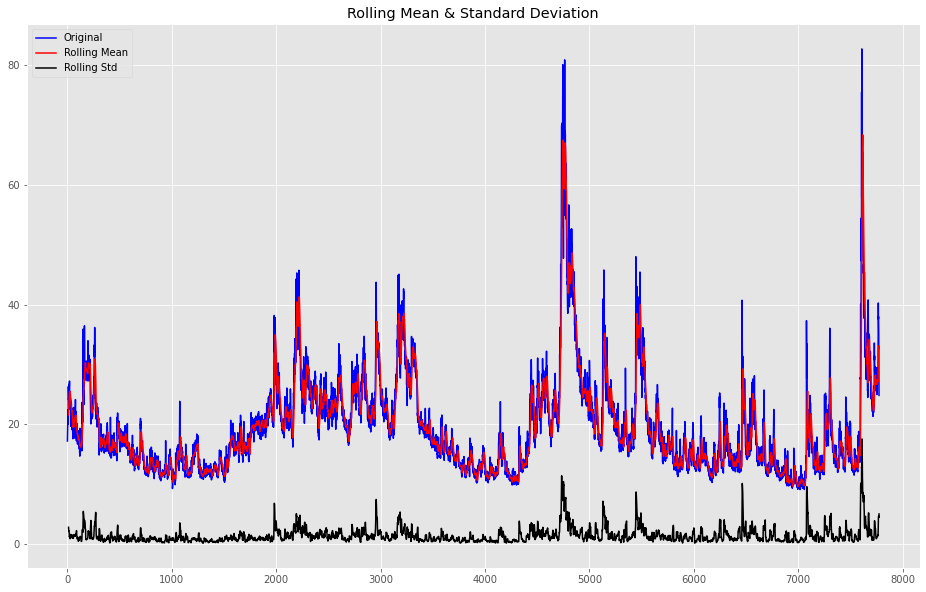

Results of Dickey-Fuller Test :
p-value = 0.0000. The series is likely stationary.


In [72]:
test_stationarity(series)

In [73]:
vix_close_diff_1 = series.diff()
vix_close_diff_1.dropna(inplace = True)

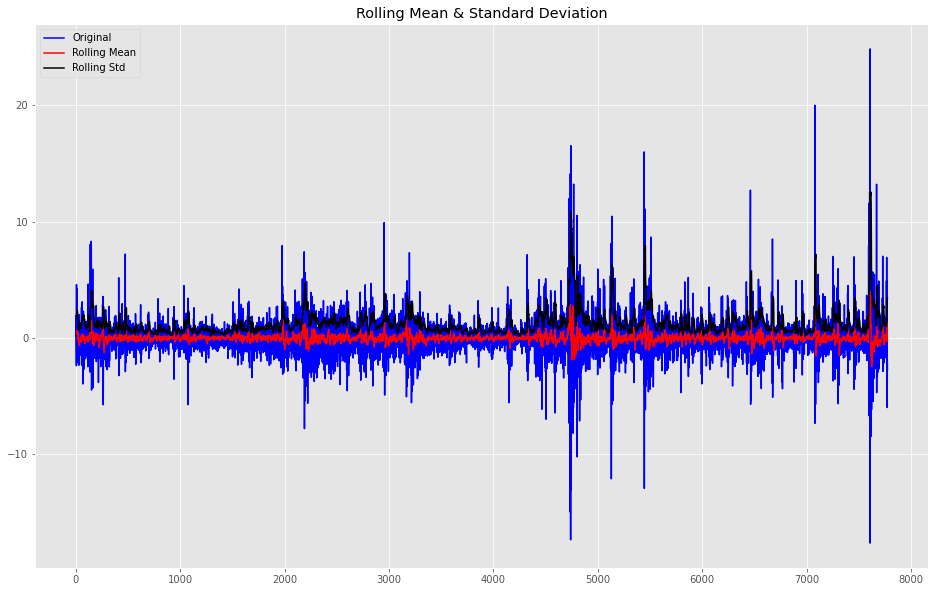

Results of Dickey-Fuller Test :
p-value = 0.0000. The series is likely stationary.


In [74]:
test_stationarity(vix_close_diff_1)

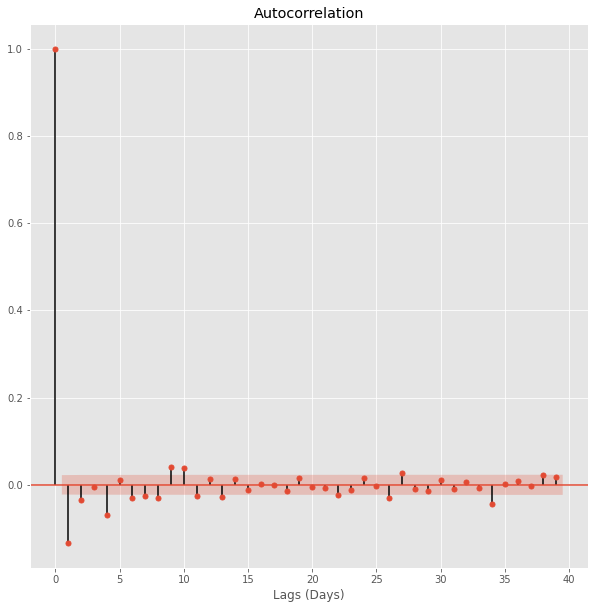

In [75]:
plot_acf(vix_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

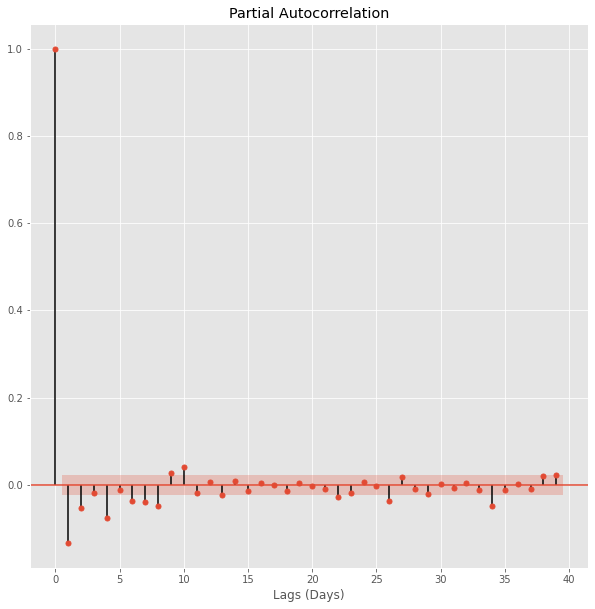

In [76]:
plot_pacf(vix_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [77]:
vix_arima = ARIMA(x_train, order = (1,1,1))
vix_arima_fit = vix_arima.fit(disp = 0)
print(vix_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2779
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4452.625
Method:                       css-mle   S.D. of innovations              1.201
Date:                Sun, 08 Nov 2020   AIC                           8913.250
Time:                        11:10:57   BIC                           8936.970
Sample:                             1   HQIC                          8921.815
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.012      0.225      0.822      -0.021       0.026
ar.L1.D.Close     0.7777      0.041     18.740      0.000       0.696       0.859
ma.L1.D.Close    -0.8825      0.032    -

In [78]:
history = [x for x in x_train]
model_predictions = []
N_test_observations = len(x_test)
for time_point in list(x_test.index) :
    model = ARIMA(history, order = (1,1,1))
    transparams = False
    model_fit = model.fit(disp = 0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is [10.35695466  8.8520481   9.65643249  9.7801311   9.92949609  9.78663474
  9.39333842  9.7217286   9.7571059   9.58530265  8.33743968  8.18164779
  7.98659763  8.78667471  9.03468372  9.00858997  8.71629504  8.64517962
  9.09896825  7.24627907  6.91779044  7.3641373   7.39581514  6.66029439
 17.76347978 12.06974808 10.59600965 14.65358055 11.45964622  9.43016543
  9.1154568   6.99812518  6.96878425  7.04348747  7.35732544  7.1862954
  6.88472529  6.65297738  6.6559589   6.8583325   7.13342735  8.00791022
  7.06795837  6.88171752  6.82000931  6.73679887  6.65336332  6.82519522
  6.65941295  6.6485544   6.68377855  6.65346618  6.66027313  6.92317269
  6.78565687  6.73957375  8.33497015  9.02117002  7.46404694  7.99555201
  8.14621678  7.15094592  8.46235382  7.49181731  7.17705688  6.91397388
  7.62107239  7.72328208  7.29589141  7.22932324  6.83666152  6.70047702
  6.6535888   6.71534492  6.67353059  6.65181889  6.66334215  6.64809732
  6.7596174   6.736730

In [82]:
%store -r model_predictions
model_predictions[:5]

[array([26.89596539]),
 array([11.53538419]),
 array([10.70022115]),
 array([10.57334626]),
 array([10.42014593])]

In [83]:
arima_mae = mean_absolute_error(x_test,model_predictions)
arima_mae

1.4216869749903556

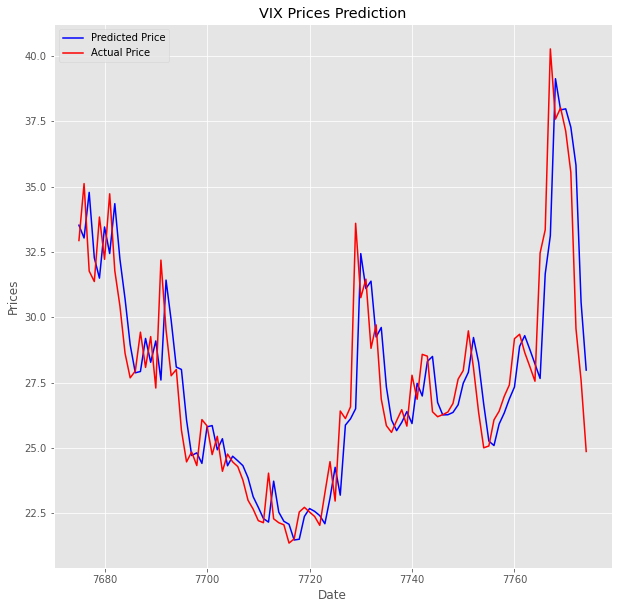

<Figure size 720x432 with 0 Axes>

In [84]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(x_test.index[-100:], model_predictions[-100:], color = 'blue',label = 'Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color = 'red', label = 'Actual Price')
plt.title('VIX Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()